# **Problem Statement:** Wafer Fault Detection

# 1. Importing Libraries

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans

from typing import Tuple
from dataclasses import dataclass
from imblearn.combine import SMOTETomek
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt

# 2. The Datasets

# 2.1 Reading Datasets

In [3]:
wafers=pd.read_csv('/content/drive/MyDrive/Colab-notebooks/wafer_23012020_041211.csv')
wafers.head()

,Unnamed: 0,Sensor-1,Sensor-2,Sensor-3,Sensor-4,Sensor-5,Sensor-6,Sensor-7,Sensor-8,Sensor-9,...,Sensor-582,Sensor-583,Sensor-584,Sensor-585,Sensor-586,Sensor-587,Sensor-588,Sensor-589,Sensor-590,Good/Bad
0,Wafer-801,2968.33,2476.58,2216.7333,1748.0885,1.1127,100.0,97.5822,0.1242,1.5300,...,NaN,0.5004,0.0120,0.0033,2.4069,0.0545,0.0184,0.0055,33.7876,-1
1,Wafer-802,2961.04,2506.43,2170.0666,1364.5157,1.5447,100.0,96.7700,0.1230,1.3953,...,NaN,0.4994,0.0115,0.0031,2.3020,0.0545,0.0184,0.0055,33.7876,1
2,Wafer-803,3072.03,2500.68,2205.7445,1363.1048,1.0518,100.0,101.8644,0.1220,1.3896,...,NaN,0.4987,0.0118,0.0036,2.3719,0.0545,0.0184,0.0055,33.7876,-1
3,Wafer-804,3021.83,2419.83,2205.7445,1363.1048,1.0518,100.0,101.8644,0.1220,1.4108,...,NaN,0.4934,0.0123,0.0040,2.4923,0.0545,0.0184,0.0055,33.7876,-1
4,Wafer-805,3006.95,2435.34,2189.8111,1084.6502,1.1993,100.0,104.8856,0.1234,1.5094,...,NaN,0.4987,0.0145,0.0041,2.8991,0.0545,0.0184,0.0055,33.7876,-1


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2.2 Test Datasets

* *Creating test datasets for testing purpose*

In [5]:
wafers.drop(columns=['Unnamed: 0']).iloc[:100].to_csv('test.csv',index=False)

# 3. Data Exploration

In [6]:
wafers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Columns: 592 entries, Unnamed: 0 to Good/Bad
dtypes: float64(494), int64(97), object(1)
memory usage: 462.6+ KB


In [7]:
wafers.describe()

,Sensor-1,Sensor-2,Sensor-3,Sensor-4,Sensor-5,Sensor-6,Sensor-7,Sensor-8,Sensor-9,Sensor-10,...,Sensor-582,Sensor-583,Sensor-584,Sensor-585,Sensor-586,Sensor-587,Sensor-588,Sensor-589,Sensor-590,Good/Bad
count,99.000000,100.000000,97.000000,97.000000,97.000000,97.0,97.000000,97.000000,100.000000,100.000000,...,34.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,3017.301212,2487.180300,2202.168281,1484.362181,1.180367,100.0,97.449088,0.122195,1.461516,0.000243,...,74.331709,0.499390,0.013615,0.003549,2.727297,0.023510,0.014875,0.004685,77.430241,-0.880000
std,71.819707,66.954212,30.350606,460.985871,0.349654,0.0,5.553324,0.002006,0.071300,0.010610,...,41.857728,0.003431,0.004344,0.000873,0.875848,0.011991,0.007557,0.002527,55.106166,0.477367
min,2825.670000,2254.990000,2114.666700,978.783200,0.753100,100.0,83.423300,0.116000,1.317900,-0.027900,...,20.309100,0.492500,0.007600,0.002100,1.515200,0.009900,0.004800,0.001700,20.309100,-1.000000
25%,2973.040000,2446.595000,2189.966700,1111.543600,0.837300,100.0,95.108900,0.120800,1.407375,-0.006925,...,47.356000,0.497300,0.011300,0.003075,2.270425,0.013400,0.009475,0.002700,33.787600,-1.000000
50%,3004.390000,2493.890000,2200.988900,1244.289900,1.156900,100.0,99.513300,0.122200,1.453700,0.001000,...,65.127550,0.499400,0.012750,0.003400,2.546400,0.021800,0.013900,0.003850,62.059500,-1.000000
75%,3070.385000,2527.525000,2213.211100,1963.801600,1.383000,100.0,101.457800,0.123400,1.507425,0.008125,...,99.419050,0.501525,0.014700,0.003825,2.953750,0.028025,0.019200,0.005900,104.303400,-1.000000
max,3221.210000,2664.520000,2315.266700,2363.641200,2.207300,100.0,107.152200,0.126200,1.641100,0.025000,...,223.101800,0.508700,0.043700,0.008900,8.816000,0.054500,0.040100,0.015000,223.101800,1.000000


In [8]:
wafers.columns.unique()

Index(['Unnamed: 0', 'Sensor-1', 'Sensor-2', 'Sensor-3', 'Sensor-4',
       'Sensor-5', 'Sensor-6', 'Sensor-7', 'Sensor-8', 'Sensor-9',
       ...
       'Sensor-582', 'Sensor-583', 'Sensor-584', 'Sensor-585', 'Sensor-586',
       'Sensor-587', 'Sensor-588', 'Sensor-589', 'Sensor-590', 'Good/Bad'],
      dtype='object', length=592)

* **Replacing Unnamed: 0 to Wafer**

In [9]:
wafers.rename(columns={'Unnamed: 0': 'Wafer'},inplace=True)

In [10]:
wafers.head(2)

,Wafer,Sensor-1,Sensor-2,Sensor-3,Sensor-4,Sensor-5,Sensor-6,Sensor-7,Sensor-8,Sensor-9,...,Sensor-582,Sensor-583,Sensor-584,Sensor-585,Sensor-586,Sensor-587,Sensor-588,Sensor-589,Sensor-590,Good/Bad
0,Wafer-801,2968.33,2476.58,2216.7333,1748.0885,1.1127,100.0,97.5822,0.1242,1.5300,...,NaN,0.5004,0.0120,0.0033,2.4069,0.0545,0.0184,0.0055,33.7876,-1
1,Wafer-802,2961.04,2506.43,2170.0666,1364.5157,1.5447,100.0,96.7700,0.1230,1.3953,...,NaN,0.4994,0.0115,0.0031,2.3020,0.0545,0.0184,0.0055,33.7876,1


* **Let's see how many wafers is good and how many bad**

In [11]:
wafers['Good/Bad'].value_counts()

-1    94
 1     6
Name: Good/Bad, dtype: int64

* This data is havily imbalanced datasets so we have to balanced it.

## 3.1 Handling Missing Value

Firstly, we'll check the missing data in the target feature and drop those records. **As if we already know a value of target feature then there's no need for a ML algorithm, damn right?** Therefore, the best way to deal with missing target entries is to delete them. For other missing features, we can definitely use impute strategies.

In [12]:
wafers['Good/Bad'].isna().sum()

0

In [13]:
wafers.isna().sum()

Wafer         0
Sensor-1      1
Sensor-2      0
Sensor-3      3
Sensor-4      3
             ..
Sensor-587    0
Sensor-588    0
Sensor-589    0
Sensor-590    0
Good/Bad      0
Length: 592, dtype: int64

In [14]:
wafers.isna().sum().sum()

2306

In [15]:
## Check missing vals in dependent feature variables

wafers.isna().sum().sum() / (wafers.shape[0] * (wafers.shape[1] - 1))

0.03901861252115059

* **Almost 4% missing data**

# 3. Data Visualization

In [16]:
plt.style.use('dark_background')

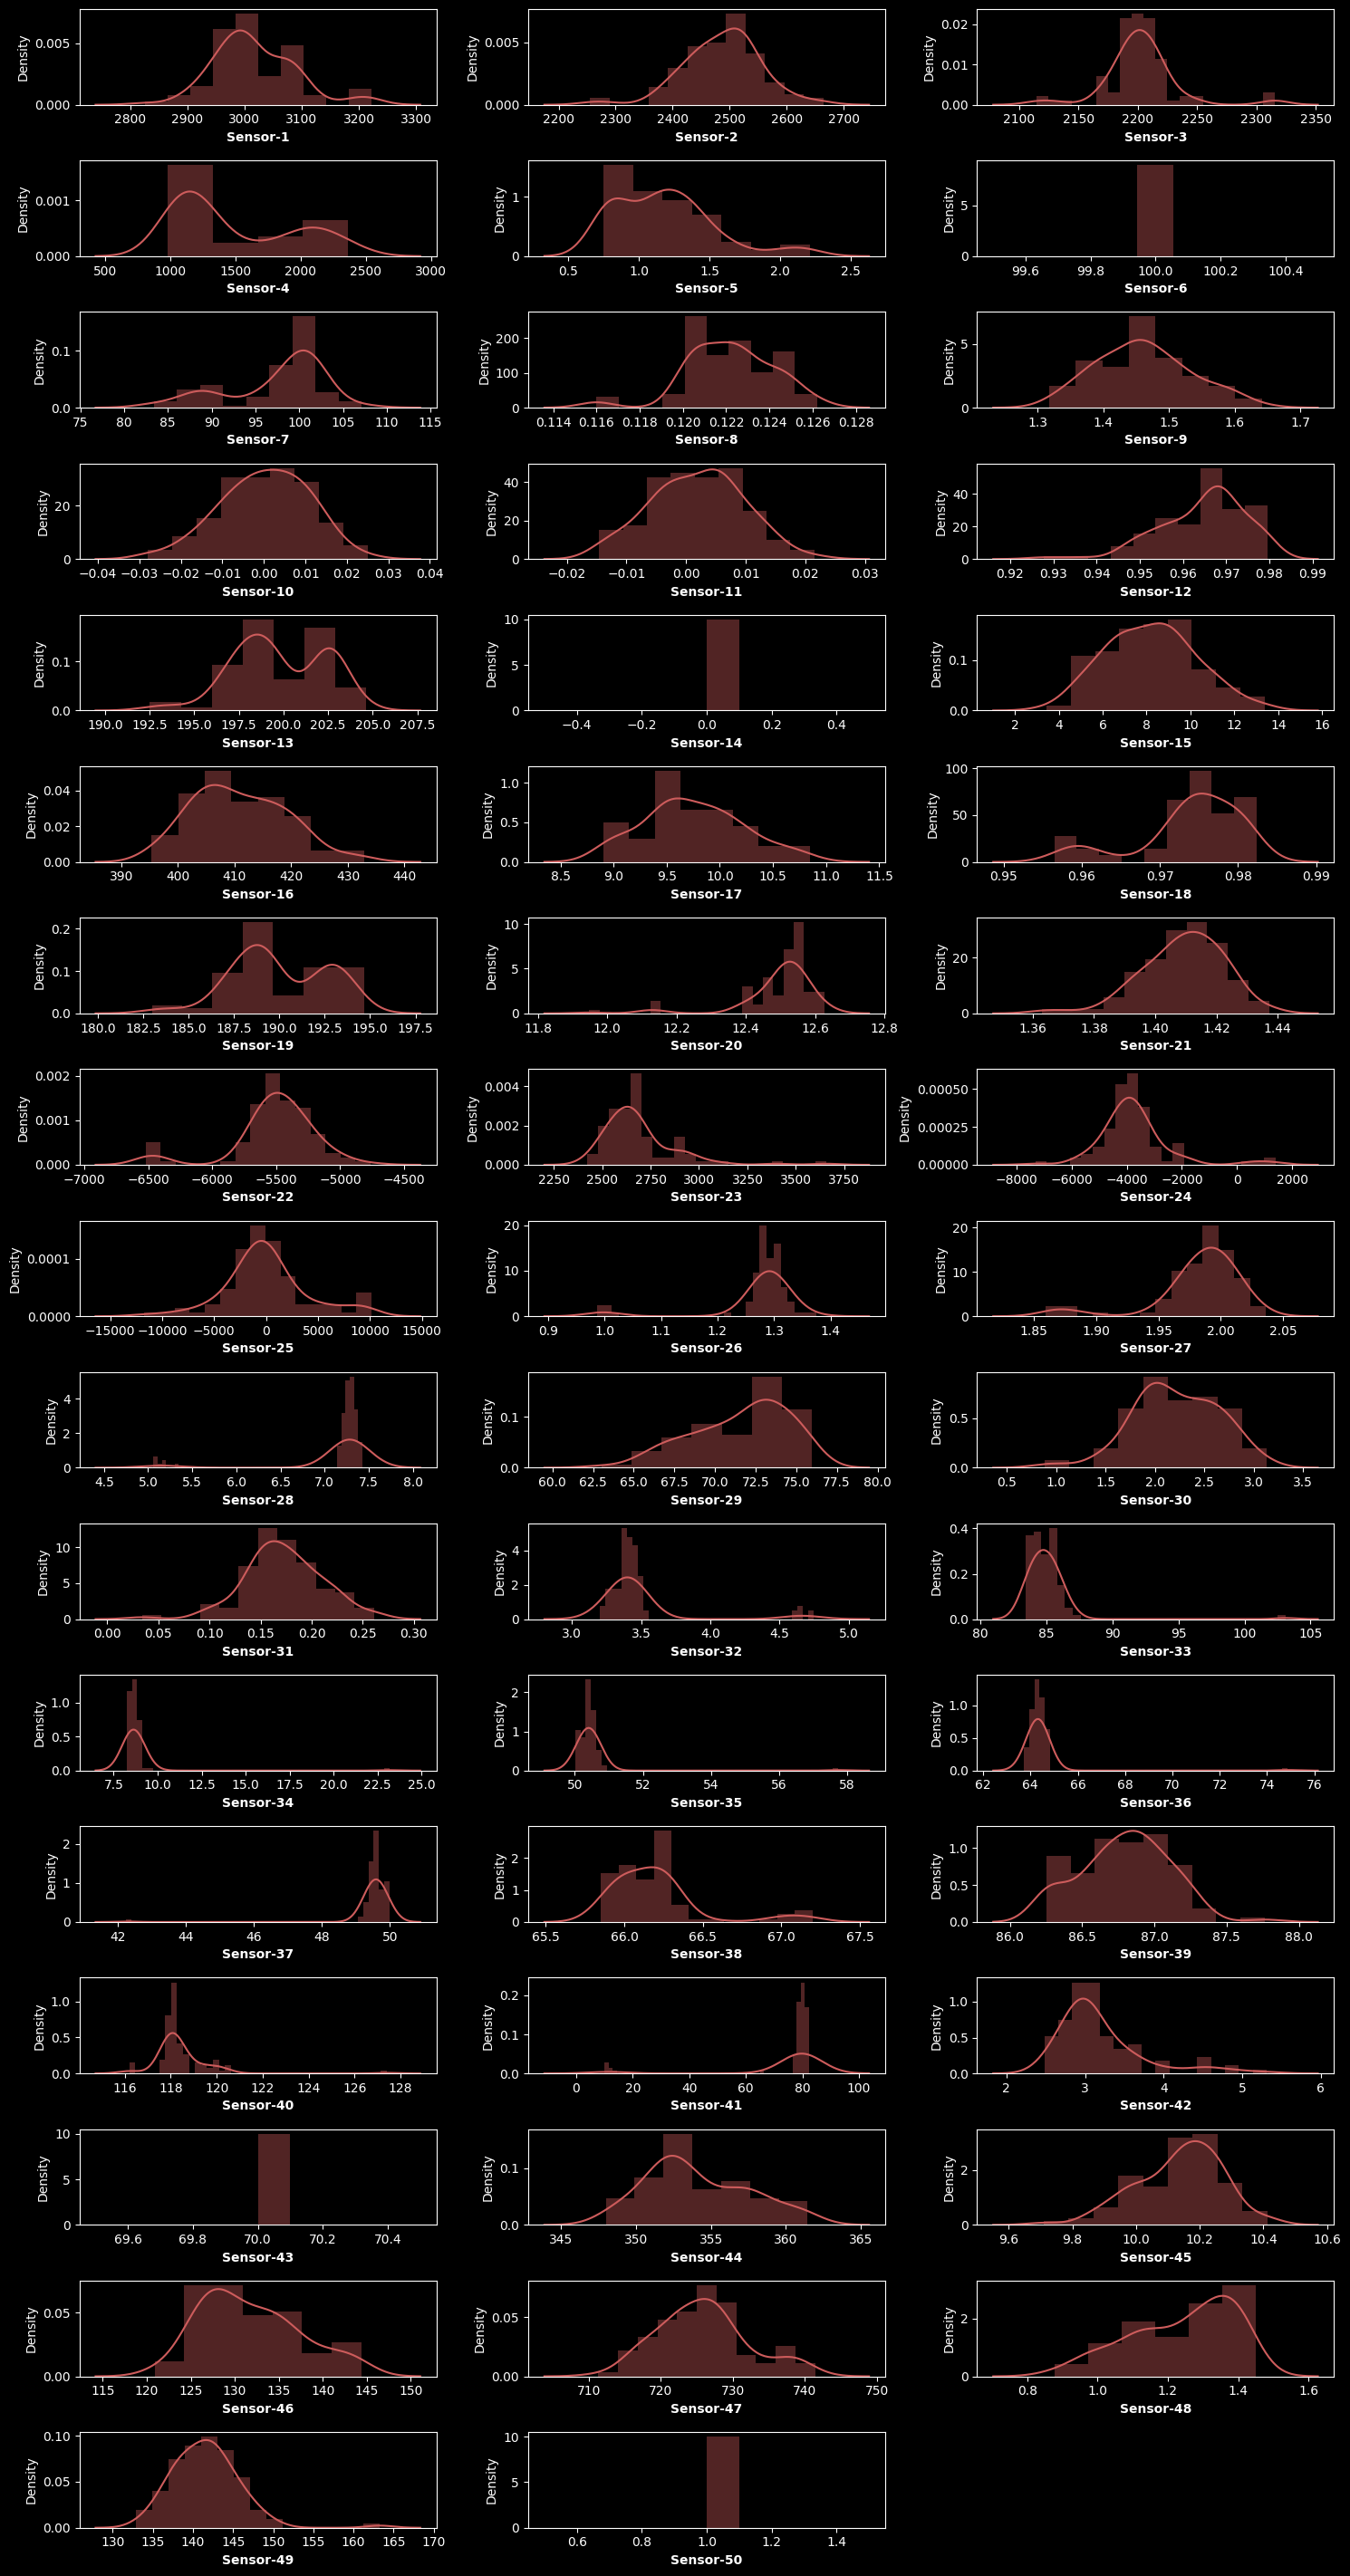

In [17]:
# let's have a look at the distribution first 50 sensors of Wafers

plt.figure(figsize=(15, 100))

for i, col in enumerate(wafers.columns[1:51]):
    plt.subplot(60, 3, i+1)
    sns.distplot(x=wafers[col], color='indianred')
    plt.xlabel(col, weight='bold')
    plt.tight_layout()

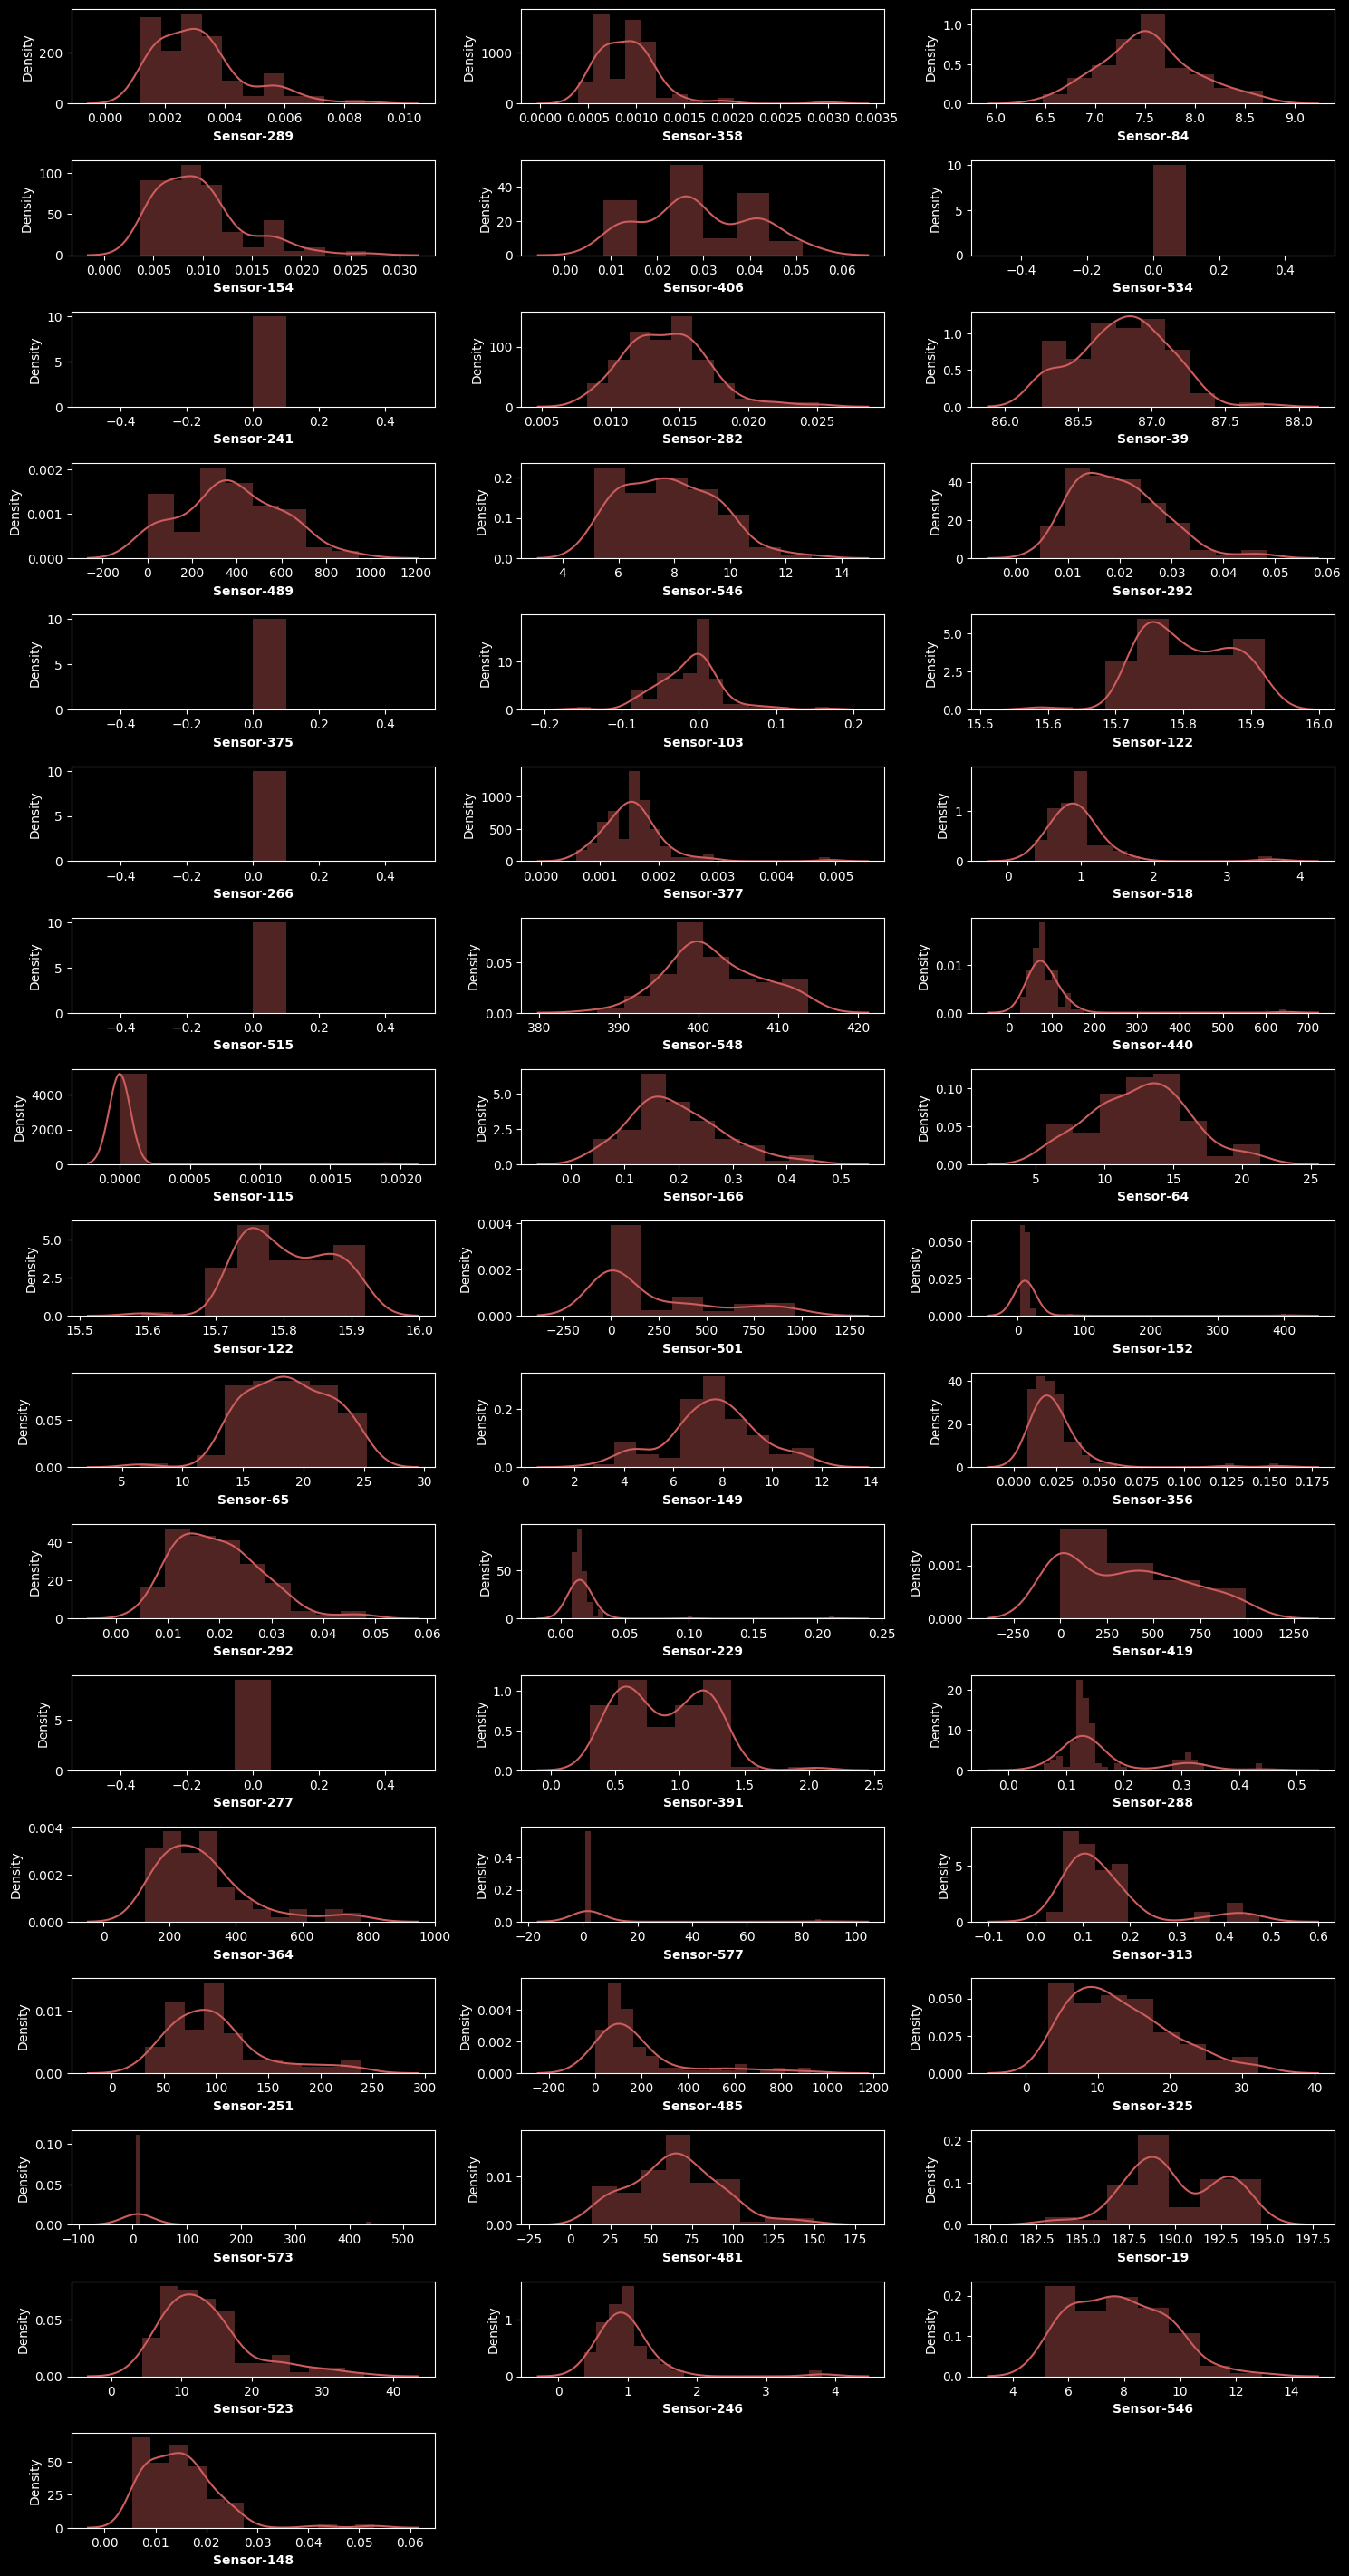

In [18]:
# Select 50 random sensors

random_50_sensors_idx = []
for i in range(50):
    if i not in random_50_sensors_idx:
        random_50_sensors_idx.append(np.random.randint(1, 591))

plt.figure(figsize=(15, 100))

for i, col in enumerate(wafers.columns[random_50_sensors_idx]):
    plt.subplot(60, 3, i+1)
    sns.distplot(x=wafers[col], color='indianred')
    plt.xlabel(col, weight='bold')
    plt.tight_layout()

* **Now we are going to drop whose columns have 0 standard deviation**

In [19]:
def get_cols_with_zero_std_dev(df: pd.DataFrame):
    """
    Returns a list of columns names who are having zero standard deviation.
    """
    cols_to_drop = []
    num_cols = [col for col in df.columns if df[col].dtype != 'O']  # numerical cols only
    for col in num_cols:
        if df[col].std() == 0:
            cols_to_drop.append(col)
    return cols_to_drop

In [20]:
## Columns w 0 Standard Deviation

cols_to_drop_2 = get_cols_with_zero_std_dev(df=wafers)
cols_to_drop_2.append("Wafer")
cols_to_drop_2

['Sensor-6',
 'Sensor-14',
 'Sensor-43',
 'Sensor-50',
 'Sensor-53',
 'Sensor-70',
 'Sensor-75',
 'Sensor-98',
 'Sensor-142',
 'Sensor-150',
 'Sensor-179',
 'Sensor-180',
 'Sensor-187',
 'Sensor-190',
 'Sensor-191',
 'Sensor-192',
 'Sensor-193',
 'Sensor-194',
 'Sensor-195',
 'Sensor-207',
 'Sensor-210',
 'Sensor-227',
 'Sensor-230',
 'Sensor-231',
 'Sensor-232',
 'Sensor-233',
 'Sensor-234',
 'Sensor-235',
 'Sensor-236',
 'Sensor-237',
 'Sensor-238',
 'Sensor-241',
 'Sensor-242',
 'Sensor-243',
 'Sensor-244',
 'Sensor-257',
 'Sensor-258',
 'Sensor-259',
 'Sensor-260',
 'Sensor-261',
 'Sensor-262',
 'Sensor-263',
 'Sensor-264',
 'Sensor-265',
 'Sensor-266',
 'Sensor-267',
 'Sensor-277',
 'Sensor-285',
 'Sensor-314',
 'Sensor-315',
 'Sensor-316',
 'Sensor-323',
 'Sensor-326',
 'Sensor-327',
 'Sensor-328',
 'Sensor-329',
 'Sensor-330',
 'Sensor-331',
 'Sensor-343',
 'Sensor-348',
 'Sensor-365',
 'Sensor-370',
 'Sensor-371',
 'Sensor-372',
 'Sensor-373',
 'Sensor-374',
 'Sensor-375',
 'Se

In [21]:
def get_redundant_cols(df: pd.DataFrame, missing_thresh=.7):
    """
    Returns a list of columns having missing values more than certain thresh.
    """
    cols_missing_ratios = df.isna().sum().div(df.shape[0])
    cols_to_drop = list(cols_missing_ratios[cols_missing_ratios > missing_thresh].index)
    return cols_to_drop

In [22]:
## Columns w missing vals more than 70%

cols_to_drop_1 = get_redundant_cols(wafers, missing_thresh=.7)
cols_to_drop_1

['Sensor-158', 'Sensor-159', 'Sensor-293', 'Sensor-294']

In [23]:
## Cols to drop

cols_to_drop = cols_to_drop_1 + cols_to_drop_2

# 4. Feature Selection

In [24]:
## Separate features and Labels out

X, y = wafers.drop(cols_to_drop, axis=1), wafers[["Good/Bad"]]
## Dependent feature variables

print("Shape of the features now: ", X.shape)
X.head()

Shape of the features now:  (100, 465)


,Sensor-1,Sensor-2,Sensor-3,Sensor-4,Sensor-5,Sensor-7,Sensor-8,Sensor-9,Sensor-10,Sensor-11,...,Sensor-582,Sensor-583,Sensor-584,Sensor-585,Sensor-586,Sensor-587,Sensor-588,Sensor-589,Sensor-590,Good/Bad
0,2968.33,2476.58,2216.7333,1748.0885,1.1127,97.5822,0.1242,1.5300,-0.0279,-0.0040,...,NaN,0.5004,0.0120,0.0033,2.4069,0.0545,0.0184,0.0055,33.7876,-1
1,2961.04,2506.43,2170.0666,1364.5157,1.5447,96.7700,0.1230,1.3953,0.0084,0.0062,...,NaN,0.4994,0.0115,0.0031,2.3020,0.0545,0.0184,0.0055,33.7876,1
2,3072.03,2500.68,2205.7445,1363.1048,1.0518,101.8644,0.1220,1.3896,0.0138,0.0000,...,NaN,0.4987,0.0118,0.0036,2.3719,0.0545,0.0184,0.0055,33.7876,-1
3,3021.83,2419.83,2205.7445,1363.1048,1.0518,101.8644,0.1220,1.4108,-0.0046,-0.0024,...,NaN,0.4934,0.0123,0.0040,2.4923,0.0545,0.0184,0.0055,33.7876,-1
4,3006.95,2435.34,2189.8111,1084.6502,1.1993,104.8856,0.1234,1.5094,-0.0046,0.0121,...,NaN,0.4987,0.0145,0.0041,2.8991,0.0545,0.0184,0.0055,33.7876,-1


In [25]:
# Independent/Target Variables

print("Shape of the labels: ", y.shape)
y.head()

Shape of the labels:  (100, 1)


,Good/Bad
0,-1
1,1
2,-1
3,-1
4,-1


# 5. Data Transformation

In [26]:
imputer = KNNImputer(n_neighbors=3)
preprocessing_pipeline = Pipeline(
    steps=[('Imputer', imputer), ('Scaler', RobustScaler())])
preprocessing_pipeline

Pipeline(steps=[('Imputer', KNNImputer(n_neighbors=3)),
                ('Scaler', RobustScaler())])

In [27]:

X_trans = preprocessing_pipeline.fit_transform(X)
print("Shape of transformed features set: ", X_trans.shape)
X_trans

Shape of transformed features set:  (100, 465)


array([[-0.37110152, -0.21388855,  0.67805794, ...,  0.515625  ,
        -0.40093   ,  0.        ],
       [-0.44644841,  0.15494872, -1.32959552, ...,  0.515625  ,
        -0.40093   ,  2.        ],
       [ 0.70070541,  0.08389967,  0.20530751, ...,  0.515625  ,
        -0.40093   ,  0.        ],
       ...,
       [ 0.83289837, -1.31558137, -1.26792905, ..., -0.671875  ,
        -0.44021198,  0.        ],
       [-0.49988372,  0.59310515, -0.16308229, ..., -0.671875  ,
        -0.44021198,  0.        ],
       [-0.92374874, -0.35561596,  0.40033513, ..., -0.671875  ,
        -0.44021198,  2.        ]])

# 6. Clsutering

In [29]:
from sklearn.cluster import KMeans
# from kneed import KneeLocator
from typing import Tuple
from dataclasses import dataclass

@dataclass
class ClusterDataInstances:
    """Divides the given data instances into different clusters via KMeans Clustering algorithm.

    Args:
        X (np.array): Takes in an array which gotta be clustered.
        desc (str): Description of the said array.
    """
    X: np.array
    desc: str

    def _get_ideal_number_of_clusters(self):
        """Returns the ideal number of clusters the given data instances should be divided into by
        locating the dispersal point in number of clusters vs WCSS plot.

        Raises:
            e: Raises relevant exception should any kinda error pops up while determining the ideal
            number of clusters.

        Returns:
            int: Ideal number of clusters the given data instances should be divided into.
        """
        try:
            print(
                f'Getting the ideal number of clusters to cluster "{self.desc} set" into..')

            ####################### Compute WCSS for shortlisted number of clusters ##########################
            print("computing WCSS for shortlisted number of clusters..")
            wcss = []  # Within Summation of Squares
            for i in range(1, 11):
                kmeans = KMeans(n_clusters=i, init='k-means++',
                                random_state=42)
                kmeans.fit(self.X)
                wcss.append(kmeans.inertia_)
                print(f"WCSS for n_clusters={i}: {kmeans.inertia_}")
            print(
                "WCSS computed successfully for all shortlisted number of clusters!")

            ################### Finalize dispersal point as the ideal number of clusters #####################
            print(
                "Finding the ideal number of clusters (by locating the dispersal point) via Elbow method..")
            knee_finder = KneeLocator(
                range(1, 11), wcss, curve='convex', direction='decreasing')  # range(1, 11) vs WCSS
            print(
                f"Ideal number of clusters to be formed: {knee_finder.knee}")

            return knee_finder.knee
            ...
        except Exception as e:
            print(e)
            raise e

    def create_clusters(self) -> Tuple:
        """Divides the given data instances into the different clusters, they first hand shoud've been divided into
        via offcourse Kmeans Clustering algorithm.

        Raises:
            e: Raises relevant exception should any kinda error pops up while dividing the given data instances into
            clusters.

        Returns:
            (KMeans, np.array): KMeans Clustering object being used to cluster the given data instances and the given dataset
            along with the cluster labels, respectively.
        """
        try:
            ideal_clusters = self._get_ideal_number_of_clusters()
            print(
                f"Dividing the \"{self.desc}\" instances into {ideal_clusters} clusters via KMeans Clustering algorithm..")
            kmeans = KMeans(n_clusters=ideal_clusters,
                            init='k-means++', random_state=42)
            y_kmeans = kmeans.fit_predict(self.X)
            print(
                f"..said data instances divided into {ideal_clusters} clusters successfully!")

            return kmeans, np.c_[self.X, y_kmeans]
            ...
        except Exception as e:
            print(e)
            raise e

In [35]:
!pip install --upgrade kneed



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
from kneed import KneeLocator

cluster_wafers = ClusterDataInstances(X=X_trans, desc="wafers features")
clusterer, X_clus = cluster_wafers.create_clusters()
X_clus

Getting the ideal number of clusters to cluster "wafers features set" into..
computing WCSS for shortlisted number of clusters..
WCSS for n_clusters=1: 1503049.6472606934
WCSS for n_clusters=2: 512194.08490126603
WCSS for n_clusters=3: 185195.115933283
WCSS for n_clusters=4: 143033.25783274247
WCSS for n_clusters=5: 108688.31540145786
WCSS for n_clusters=6: 88439.04360341991
WCSS for n_clusters=7: 81079.41259322356
WCSS for n_clusters=8: 68622.79634876264
WCSS for n_clusters=9: 61805.448381217175
WCSS for n_clusters=10: 58870.60322516474
WCSS computed successfully for all shortlisted number of clusters!
Finding the ideal number of clusters (by locating the dispersal point) via Elbow method..
Ideal number of clusters to be formed: 3
Dividing the "wafers features" instances into 3 clusters via KMeans Clustering algorithm..
..said data instances divided into 3 clusters successfully!


array([[-0.37110152, -0.21388855,  0.67805794, ..., -0.40093   ,
         0.        ,  0.        ],
       [-0.44644841,  0.15494872, -1.32959552, ..., -0.40093   ,
         2.        ,  0.        ],
       [ 0.70070541,  0.08389967,  0.20530751, ..., -0.40093   ,
         0.        ,  0.        ],
       ...,
       [ 0.83289837, -1.31558137, -1.26792905, ..., -0.44021198,
         0.        ,  0.        ],
       [-0.49988372,  0.59310515, -0.16308229, ..., -0.44021198,
         0.        ,  0.        ],
       [-0.92374874, -0.35561596,  0.40033513, ..., -0.44021198,
         2.        ,  0.        ]])

In [37]:
## Clusters

np.unique(X_clus[:, -1])

array([0., 1., 2.])

* **The datasets is divided into 3 cluster**

In [38]:
## Configure "Clustered" array along with target features
wafers_clus = np.c_[X_clus, y]

## Cluster_1 data
wafers_1 = wafers_clus[wafers_clus[:, -2] == 0]
wafers_1.shape

(96, 467)

* **Perhaps we were wrong about dividing the `Wafers` dataset into clusters, as we can see pretty much of all datapoints lie in the first cluster itself.**

Let's take look at another clusters anyway..

In [39]:
## Cluster_2 data

wafers_clus[wafers_clus[:, -2] == 1].shape

(3, 467)

In [40]:
## Cluster_3 data

wafers_clus[wafers_clus[:, -2] == 2].shape

(1, 467)

* **Thus we mustn't divide the dataset into clusters. Not a good idea!**

# 7. Reasamplig Datasets

In [41]:
X, y = X_trans[:, :-1], y
resampler = SMOTETomek(sampling_strategy="auto")
X_res, y_res = resampler.fit_resample(X, y)

In [42]:
print("Before resampling, Shape of training instances: ", np.c_[X, y].shape)
print("After resampling, Shape of training instances: ", np.c_[X_res, y_res].shape)

Before resampling, Shape of training instances:  (100, 465)
After resampling, Shape of training instances:  (188, 465)


In [43]:


print(np.unique(y_res))
print(f"Value Counts: \n-1: {len(y_res[y_res == -1])}, 1: {len(y_res[y_res == 1])}")

[-1  1]
Value Counts: 
-1: 188, 1: 188


# 8. Model Training

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=1/3, random_state=42)

print(f"train set: {X_train.shape, y_train.shape}")
print(f"test set: {X_test.shape, y_test.shape}")

train set: ((125, 464), (125, 1))
test set: ((63, 464), (63, 1))


In [45]:
# Prepared training and test sets

X_prep = X_train
y_prep = y_train
X_test_prep = X_test
y_test_prep = y_test

print(X_prep.shape, y_prep.shape)
print(X_test_prep.shape, y_test_prep.shape)

(125, 464) (125, 1)
(63, 464) (63, 1)


In [46]:
 #Shortlisted base Models
svc_clf = SVC(kernel='linear')
svc_rbf_clf = SVC(kernel='rbf')
random_clf = RandomForestClassifier(random_state=42)
xgb_clf = XGBClassifier(objective='binary:logistic')

In [47]:
## A function to display Scores

def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard Deviation: ", scores.std())

## 8.1 SVC (Kernel='linear')

In [48]:
## SVC Scores

svc_scores = cross_val_score(svc_clf, X_prep, y_prep, scoring='roc_auc', cv=10, verbose=2)

[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished


In [49]:
display_scores(svc_scores)

Scores:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean:  1.0
Standard Deviation:  0.0


In [50]:
## Performance on test set using cross-validation

# Predictions using cross-validation
svc_preds = cross_val_predict(svc_clf, X_test_prep, y_test_prep, cv=5)

# AUC score
svc_auc = roc_auc_score(y_test_prep, svc_preds)
svc_auc

0.9558823529411764

## 8.2 SVC (kerne='rbf')

In [51]:
## SVC rbf Scores

svc_rbf_scores = cross_val_score(svc_rbf_clf, X_prep, y_prep, scoring='roc_auc', cv=10, verbose=2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished


In [52]:
display_scores(svc_rbf_scores)

Scores:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean:  1.0
Standard Deviation:  0.0


In [53]:
## Performance on test set using cross-validation

# Predictions using cross-validation
svc_rbf_preds = cross_val_predict(svc_rbf_clf, X_test_prep, y_test_prep, cv=5)

# AUC score
svc_rbf_auc = roc_auc_score(y_test_prep, svc_rbf_preds)
svc_rbf_auc

0.9188640973630832

## 8.3 RandomForestClassifier

In [54]:
## Random Forest Scores

random_clf_scores = cross_val_score(random_clf, X_prep, y_prep, scoring='roc_auc', cv=10, verbose=2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] END .................................................... total time=   0.9s
[CV] END .................................................... total time=   0.9s
[CV] END .................................................... total time=   1.0s
[CV] END .................................................... total time=   0.9s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.5s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.9s finished


In [55]:
display_scores(random_clf_scores)

Scores:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean:  1.0
Standard Deviation:  0.0


In [56]:
## Performance on test set using cross-validation

# Predictions using cross-validation
random_clf_preds = cross_val_predict(random_clf, X_test_prep, y_test_prep, cv=5)

# AUC score
random_clf_auc = roc_auc_score(y_test_prep, random_clf_preds)
random_clf_auc

1.0